Status Optimal
Vrijednost kriterija:  14444.0
Raspored


0        1        2        3        4        5        6      
   1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N
0   0  1  0  0  0  0  0  0  0  1  0  0  0  1  0  0  1  0  0  1  0
1   0  1  0  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0
2   0  0  1  0  0  0  1  0  0  1  0  0  0  1  0  0  0  1  0  0  0
3   0  1  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0
4   0  1  0  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0
5   0  0  1  0  0  0  1  0  0  1  0  0  1  0  0  1  0  0  0  0  1
6   0  1  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0
7   1  0  0  1  0  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0
8   0  0  0  1  0  0  1  0  0  0  0  0  1  0  0  1  0  0  1  0  0
9   1  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  1  0  0  0  0
10  0  0  1  0  0  0  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0
11  1  0  0  1  0  0  0  1  0  0  0  0  1  0  0  1  0  0  0  0  0
12  0  0  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0  0
13  1  0  0  1  0  0  0  1  0  0  1  0  0  0  0  1  0  0  0  0  0
14  1  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0
15  0  1  0  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0
16  0  1  0  0  1  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  1
17  0  0  1  0  0  0  1  0  0  0  0  0  0  1  0  0  1  0  0  0  1
18  1  0  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  0  0  0
19  0  1  0  0  0  0  0  1  0  0  0  1  0  0  1  0  0  0  1  0  0

Ukupan broj radnih dana u sedmici po sestrama


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Working days in week,5,6,5,6,6,6,6,6,5,5,5,5,5,5,6,6,5,5,5,5



Ukupan broj medicinskih sestara po smjeni


0        1        2         3        4        5        6     \
                 1M 2D 3N 1M 2D 3N 1M  2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D   
Nurses per shift  6  8  4  5  6  3  5  10  4  4  6  2  4  7  5  6  7  5  3  5   

                     
                 3N  
Nurses per shift  3

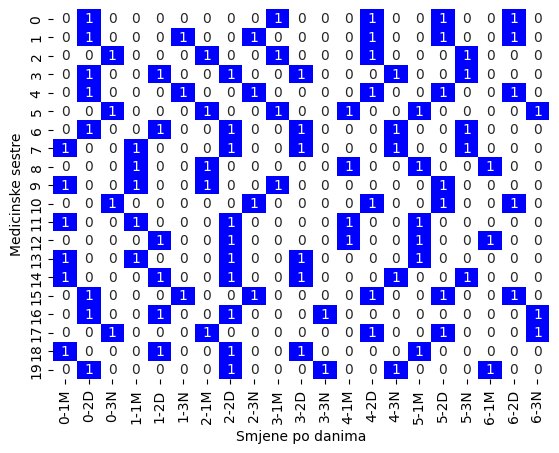

In [13]:
#Scenario 1

from pulp import *
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def NSP_constraints(days, nurses_count, ms,ds,ns,fs, problem, demand, payrates, seniority):
    
    #ogranicenje 1: samo jedna smjena dnevno
    for i in range(days):
        for j in range(nurses_count):
            c = None
            #moze naravno i ms+ds+ns<=1, izdvajamo posebno slobodan dan
            c += ms[i][j] + ds[i][j] + ns[i][j]+fs[i][j]
            problem += c == 1

    #ogranicenje 2: minimalan broj sestra u određenoj smjeni
    for i in range(days):
        morning_shift = None
        day_shift = None
        night_shift = None
        for j in range(nurses_count):
            #morning_shift+=2*ms[i][j] if seniority[j]>=7 else ms[i][j]
            #day_shift+=2*ds[i][j] if seniority[j]>=7 else ds[i][j]
            #night_shift+=2*ns[i][j] if seniority[j]>=7 else ns[i][j]
            morning_shift += ms[i][j]
            day_shift += ds[i][j]
            night_shift += ns[i][j]
        
        #uvazena su i gornja ogranicenja   
        problem += morning_shift >= demand[i][0][0]
        problem += morning_shift <= demand[i][0][1]
        problem += day_shift >= demand[i][1][0]
        problem += day_shift <= demand[i][1][1]
        problem += night_shift >= demand[i][2][0]
        problem += night_shift <= demand[i][2][1]

    # ogranicenje 3: u 7 dana minimalno 5 radnih,a maksimalno 6
    for j in range(nurses_count):
        for i in range(0, days-6):
            c = None
            for l in range(7):
                c += ms[i+l][j] + ds[i+l][j]+ns[i+l][j]
            problem += c <= 6
            problem+=c>=5

    # ogranicenje 4: minimalan odmor između dva radna dana iznosi 2 smjene
    for i in range(days-1):
        for j in range(nurses_count):
            c = None
            d= None
            e=None
            c += ns[i][j]+ms[i+1][j]
            d += ns[i][j]+ds[i+1][j]
            e += ds[i][j]+ms[i+1][j]
            problem += c <= 1
            problem += d <= 1
            problem += e <= 1
            
    #ogranicenje 5: nocni rad maksimalno 2 puta sedmicno       
    for j in range(nurses_count):
        for i in range(0, days-6):
            c = None
            for l in range(7):
                c += ns[i+l][j]
            problem += c <= 2
            
def NSP_objective(days, nurses_count, ms,ds,ns,fs, payrates):

    #kriterij - minimizacija novca za plate
    obj = None

    #cijena regularnog rada za sve sestre
    for i in range(days):
        for j in range(nurses_count):
            #nocna 150%, mnozi se sa 8 sati i satnicom
            obj+=(ms[i][j]+ds[i][j]+night_work_coef*ns[i][j])*8*payrates[j]
    
    #cijena prekovremenog rada za sve sestre
    for j in range(nurses_count):
        number_of_shifts=0
        for i in range(days):
            number_of_shifts+=ms[i][j]+ds[i][j]+ns[i][j]
        #0 ili 1
        obj+=(number_of_shifts-5)*8*(overtime_coef-1)*payrates[j]   
        
    return obj

def convert_values_to_int(dict):
    for i in range(len(dict)):
        for j in range(len(dict[0])):
            dict[i][j]=int(dict[i][j].varValue)
            
def convert_dict_of_dicts_to_list_of_lists(dict):
    my_list=[]
    for i in range(len(dict[0])):
        array=[]
        for j in range(len(dict)):
            array.append(int(dict[j][i]))
        my_list.append(array)
    return my_list

#Naredna funkcija je preuzeta sa stack overflowa
#https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png
def save_df_as_image(df, path):
    # Set background to white
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
            [norm( 1.0), "blue"]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    # Make plot
    plot = sns.heatmap(df, annot=True, cmap=cmap, cbar=False)
    fig = plot.get_figure()
    fig.gca().set_xlabel('Smjene po danima')
    fig.gca().set_ylabel('Medicinske sestre')
    fig.savefig(path, bbox_inches="tight")
    
def print_everything(ms,ds,ns,fs, table_name):
    #ms,ds,ns,fs sada imaju vrijednosti 0 ili 1 u sebi
    convert_values_to_int(ms)
    convert_values_to_int(ds)
    convert_values_to_int(ns)
    convert_values_to_int(fs)

    ms=convert_dict_of_dicts_to_list_of_lists(ms)
    ds=convert_dict_of_dicts_to_list_of_lists(ds)
    ns=convert_dict_of_dicts_to_list_of_lists(ns)
    fs=convert_dict_of_dicts_to_list_of_lists(fs)

    schedule=copy.copy(ms)
               
    #od rasporeda za jutro proširi do rasporeda za cijeli dan
    for i in range(len(ms)):
        schedule[i]=ms[i]+ds[i]+ns[i]
        
        
    morning_tuples=[(i,'1M') for i in range(len(ms[0]))]
    day_tuples=[(i,'2D') for i in range(len(ds[0]))]
    night_tuples=[(i,'3N') for i in range(len(ns[0]))]
    #free_tuples=[(i,'F') for i in range(len(fs[0]))]
    cols=pd.MultiIndex.from_tuples(morning_tuples+day_tuples+night_tuples)

    lista=['Nurse '+str(i+1) for i in range(len(ms))]

    df=pd.DataFrame(schedule, columns=cols)
    df=df.sort_index(axis=1, level=0)

    print('Raspored')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df)
        
    save_df_as_image(df, table_name)

    s=df.sum(axis=1)
    s.name='Working days in week'
    df1 = s.to_frame()
    df1=df1.transpose()
    print('Ukupan broj radnih dana u sedmici po sestrama')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df1)

    print()
    s=df.sum(axis=0) 
    s.name='Nurses per shift'
    df2 = s.to_frame()
    df2=df2.transpose()
    print('Ukupan broj medicinskih sestara po smjeni')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df2)
            
#--------------------------------------------------------------------------


#godine iskustva za pojedine sestre
seniority=[7,4,5,1,1,
            2,2,4,9,12,
            5,5,8,4,1, 
            2, 4, 5, 5, 3]

#satnice za pojedice sestre
payrates=[18, 13, 14, 10, 11,
          11, 13, 12, 20, 24,
          15, 16, 19, 17, 12, 
          13 ,15, 15, 17, 14]

#minimalan i maksimalan broj medicinskih sestara za određenu smjenu na određeni dan
#dolje navedeni brojevi se odnose na 7 dana, za više dana dodati dodatne liste
demand= [[(6, 9), (8, 13), (4, 8)], [(5, 8), (6, 10), (3, 6)], [(5, 10), (10, 14), (4, 6)],[(4, 7), (6, 9), (2, 5)],
        [(4, 7), (7, 12), (5, 7)], [(6, 9), (7, 10), (5, 7)], [(3, 5), (5, 8), (3, 5)]]
    
days=7
nurses_count=len(payrates)
night_work_coef=1.5
overtime_coef=1.5

#ms,ds,ns,fs skraćeno za morning shift,..., free shift
ms= LpVariable.dicts('Morning', (range(days), range(nurses_count)), 0, 1, 'Binary')
ds = LpVariable.dicts('Day', (range(days), range(nurses_count)), 0, 1, 'Binary')
ns = LpVariable.dicts('Night', (range(days), range(nurses_count)), 0, 1, 'Binary')
fs = LpVariable.dicts('Free', (range(days), range(nurses_count)), 0, 1, 'Binary')

problem = LpProblem('Nurse-scheduling', LpMinimize)   
problem+=NSP_objective(days, nurses_count, ms,ds,ns,fs, payrates)     
NSP_constraints(days, nurses_count, ms,ds,ns,fs, problem, demand, payrates, seniority)

status = problem.solve(pulp.PULP_CBC_CMD(timeLimit=30))
print('Status', LpStatus[status])
print('Vrijednost kriterija: ', value(problem.objective))


if(LpStatus[status]=='Optimal'):
    print_everything(ms,ds,ns,fs,'table1.png')

Status Optimal
Vrijednost kriterija:  13056.0
Raspored


0        1        2        3        4        5        6      
   1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N
0   0  0  1  0  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  0
1   0  1  0  0  1  0  0  1  0  0  0  0  0  1  0  0  0  0  1  0  0
2   0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0  0
3   0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1
4   0  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0
5   0  0  1  0  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  0
6   0  1  0  0  1  0  0  1  0  0  1  0  0  0  0  0  1  0  0  0  0
7   0  0  1  0  0  0  0  0  1  0  0  0  1  0  0  1  0  0  1  0  0
8   0  1  0  0  0  1  0  0  0  0  0  1  0  0  0  1  0  0  0  1  0
9   1  0  0  1  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  1  0
10  0  1  0  0  0  0  0  1  0  0  0  0  1  0  0  1  0  0  0  1  0
11  0  1  0  0  1  0  0  0  0  1  0  0  0  0  0  1  0  0  0  1  0
12  1  0  0  0  1  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  1
13  0  0  0  1  0  0  1  0  0  0  1  0  0  0  0  1  0  0  1  0  0
14  0  0  0  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0
15  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0  0
16  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  0  1  0  0  0  0
17  1  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  1  0  0  0  0
18  0  1  0  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  0  0
19  1  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0

Ukupan broj radnih dana u sedmici po sestrama


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Working days in week,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5



Ukupan broj medicinskih sestara po smjeni


0        1        2        3        4        5        6     \
                 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D   
Nurses per shift  4  7  3  5  6  2  6  9  3  6  6  1  5  7  3  5  7  4  4  5   

                     
                 3N  
Nurses per shift  2

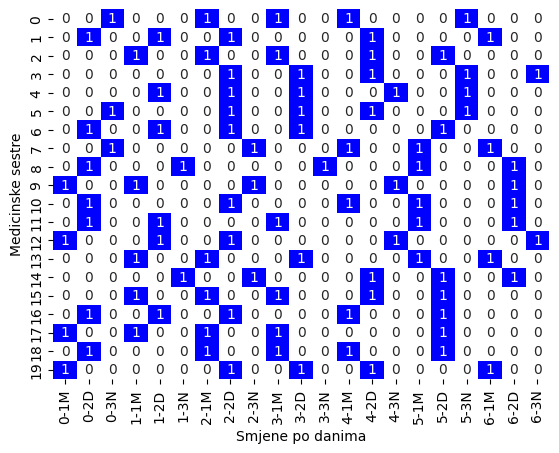

In [14]:
#Scenario 2 - medicinske sestre koje imaju seniority level(iskustvo) veće od 7 obavljaju posao za 2 sestre

from pulp import *
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def NSP_constraints(days, nurses_count, ms,ds,ns,fs, problem, demand, payrates, seniority):
    
    #ogranicenje 1: samo jedna smjena dnevno
    for i in range(days):
        for j in range(nurses_count):
            c = None
            #moze naravno i ms+ds+ns<=1, izdvajamo posebno slobodan dan
            c += ms[i][j] + ds[i][j] + ns[i][j]+fs[i][j]
            problem += c == 1

    #ogranicenje 2: minimalan broj sestra u određenoj smjeni
    for i in range(days):
        morning_shift = None
        day_shift = None
        night_shift = None
        for j in range(nurses_count):
            morning_shift+=2*ms[i][j] if seniority[j]>=7 else ms[i][j]
            day_shift+=2*ds[i][j] if seniority[j]>=7 else ds[i][j]
            night_shift+=2*ns[i][j] if seniority[j]>=7 else ns[i][j]
        
        #uvazena su i gornja ogranicenja   
        problem += morning_shift >= demand[i][0][0]
        problem += morning_shift <= demand[i][0][1]
        problem += day_shift >= demand[i][1][0]
        problem += day_shift <= demand[i][1][1]
        problem += night_shift >= demand[i][2][0]
        problem += night_shift <= demand[i][2][1]

    # ogranicenje 3: u 7 dana minimalno 5 radnih,a maksimalno 6
    for j in range(nurses_count):
        for i in range(0, days-6):
            c = None
            for l in range(7):
                c += ms[i+l][j] + ds[i+l][j]+ns[i+l][j]
            problem += c <= 6
            problem+=c>=5

    # ogranicenje 4: minimalan odmor između dva radna dana iznosi 2 smjene
    for i in range(days-1):
        for j in range(nurses_count):
            c = None
            d= None
            e=None
            c += ns[i][j]+ms[i+1][j]
            d += ns[i][j]+ds[i+1][j]
            e += ds[i][j]+ms[i+1][j]
            problem += c <= 1
            problem += d <= 1
            problem += e <= 1
            
    #ogranicenje 5: nocni rad maksimalno 2 puta sedmicno       
    for j in range(nurses_count):
        for i in range(0, days-6):
            c = None
            for l in range(7):
                c += ns[i+l][j]
            problem += c <= 2
            
def NSP_objective(days, nurses_count, ms,ds,ns,fs, payrates):

    #kriterij - minimizacija novca za plate
    obj = None

    #cijena regularnog rada za sve sestre
    for i in range(days):
        for j in range(nurses_count):
            #nocna 150%, mnozi se sa 8 sati i satnicom
            obj+=(ms[i][j]+ds[i][j]+night_work_coef*ns[i][j])*8*payrates[j]
    
    #cijena prekovremenog rada za sve sestre
    for j in range(nurses_count):
        number_of_shifts=0
        for i in range(days):
            number_of_shifts+=ms[i][j]+ds[i][j]+ns[i][j]
        #0 ili 1
        obj+=(number_of_shifts-5)*8*(overtime_coef-1)*payrates[j]   
        
    return obj

def convert_values_to_int(dict):
    for i in range(len(dict)):
        for j in range(len(dict[0])):
            dict[i][j]=int(dict[i][j].varValue)
            
def convert_dict_of_dicts_to_list_of_lists(dict):
    my_list=[]
    for i in range(len(dict[0])):
        array=[]
        for j in range(len(dict)):
            array.append(int(dict[j][i]))
        my_list.append(array)
    return my_list

#Naredna funkcija je preuzeta sa stack overflowa
#https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png
def save_df_as_image(df, path):
    # Set background to white
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
            [norm( 1.0), "blue"]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    # Make plot
    plot = sns.heatmap(df, annot=True, cmap=cmap, cbar=False)
    fig = plot.get_figure()
    fig.gca().set_xlabel('Smjene po danima')
    fig.gca().set_ylabel('Medicinske sestre')
    fig.savefig(path, bbox_inches="tight")
    
def print_everything(ms,ds,ns,fs, table_name):
    #ms,ds,ns,fs sada imaju vrijednosti 0 ili 1 u sebi
    convert_values_to_int(ms)
    convert_values_to_int(ds)
    convert_values_to_int(ns)
    convert_values_to_int(fs)

    ms=convert_dict_of_dicts_to_list_of_lists(ms)
    ds=convert_dict_of_dicts_to_list_of_lists(ds)
    ns=convert_dict_of_dicts_to_list_of_lists(ns)
    fs=convert_dict_of_dicts_to_list_of_lists(fs)

    schedule=copy.copy(ms)
               
    #od rasporeda za jutro proširi do rasporeda za cijeli dan
    for i in range(len(ms)):
        schedule[i]=ms[i]+ds[i]+ns[i]
        
        
    morning_tuples=[(i,'1M') for i in range(len(ms[0]))]
    day_tuples=[(i,'2D') for i in range(len(ds[0]))]
    night_tuples=[(i,'3N') for i in range(len(ns[0]))]
    #free_tuples=[(i,'F') for i in range(len(fs[0]))]
    cols=pd.MultiIndex.from_tuples(morning_tuples+day_tuples+night_tuples)

    lista=['Nurse '+str(i+1) for i in range(len(ms))]

    df=pd.DataFrame(schedule, columns=cols)
    df=df.sort_index(axis=1, level=0)

    print('Raspored')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df)
        
    save_df_as_image(df, table_name)

    s=df.sum(axis=1)
    s.name='Working days in week'
    df1 = s.to_frame()
    df1=df1.transpose()
    print('Ukupan broj radnih dana u sedmici po sestrama')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df1)

    print()
    s=df.sum(axis=0) 
    s.name='Nurses per shift'
    df2 = s.to_frame()
    df2=df2.transpose()
    print('Ukupan broj medicinskih sestara po smjeni')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df2)
            
#--------------------------------------------------------------------------


#godine iskustva za pojedine sestre
seniority=[7,4,5,1,1,
            2,2,4,9,12,
            5,5,8,4,1, 
            2, 4, 5, 5, 3]

#satnice za pojedice sestre
payrates=[18, 13, 14, 10, 11,
          11, 13, 12, 20, 24,
          15, 16, 19, 17, 12, 
          13 ,15, 15, 17, 14]

#minimalan i maksimalan broj medicinskih sestara za određenu smjenu na određeni dan
#dolje navedeni brojevi se odnose na 7 dana, za više dana dodati dodatne liste
demand= [[(6, 9), (8, 13), (4, 8)], [(5, 8), (6, 10), (3, 6)], [(5, 10), (10, 14), (4, 6)],[(4, 7), (6, 9), (2, 5)],
        [(4, 7), (7, 12), (5, 7)], [(6, 9), (7, 10), (5, 7)], [(3, 5), (5, 8), (3, 5)]]
    
days=7
nurses_count=len(payrates)
night_work_coef=1.5
overtime_coef=1.5

#ms,ds,ns,fs skraćeno za morning shift,..., free shift
ms= LpVariable.dicts('Morning', (range(days), range(nurses_count)), 0, 1, 'Binary')
ds = LpVariable.dicts('Day', (range(days), range(nurses_count)), 0, 1, 'Binary')
ns = LpVariable.dicts('Night', (range(days), range(nurses_count)), 0, 1, 'Binary')
fs = LpVariable.dicts('Free', (range(days), range(nurses_count)), 0, 1, 'Binary')

problem = LpProblem('Nurse-scheduling', LpMinimize)   
problem+=NSP_objective(days, nurses_count, ms,ds,ns,fs, payrates)     
NSP_constraints(days, nurses_count, ms,ds,ns,fs, problem, demand, payrates, seniority)


status = problem.solve(pulp.PULP_CBC_CMD(timeLimit=30))
print('Status', LpStatus[status])
print('Vrijednost kriterija: ', value(problem.objective))


if(LpStatus[status]=='Optimal'):
    print_everything(ms,ds,ns,fs, 'table2.png')


Status Optimal
Vrijednost kriterija:  11552.0
Raspored


0        1        2        3        4        5        6      
   1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N
0   0  1  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0
1   0  1  0  0  1  0  0  1  0  0  0  0  0  0  0  1  0  0  0  1  0
2   0  1  0  0  1  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0
3   1  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  0
4   0  1  0  0  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1
5   0  0  1  0  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  0
6   0  0  0  1  0  0  0  1  0  0  1  0  0  1  0  0  1  0  0  0  0
7   0  1  0  0  0  1  0  0  1  0  0  0  1  0  0  0  1  0  0  0  0
8   1  0  0  1  0  0  0  1  0  0  0  1  0  0  1  0  0  0  1  0  0
9   0  1  0  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0  0  0
10  1  0  0  0  0  0  1  0  0  0  1  0  0  0  0  1  0  0  0  1  0
11  1  0  0  1  0  0  0  1  0  0  0  0  0  0  0  1  0  0  1  0  0
12  0  0  1  0  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0  1
13  1  0  0  0  1  0  0  1  0  0  0  0  0  0  0  1  0  0  0  1  0
14  0  0  1  0  0  0  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0
15  0  0  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  0  0

Ukupan broj radnih dana u sedmici po sestrama


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Working days in week,6,5,5,6,6,5,5,5,6,5,5,5,6,5,5,5



Ukupan broj medicinskih sestara po smjeni


0        1        2        3        4        5        6     \
                 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D   
Nurses per shift  5  6  3  4  5  2  4  8  3  3  5  1  3  6  3  5  6  4  2  5   

                     
                 3N  
Nurses per shift  2

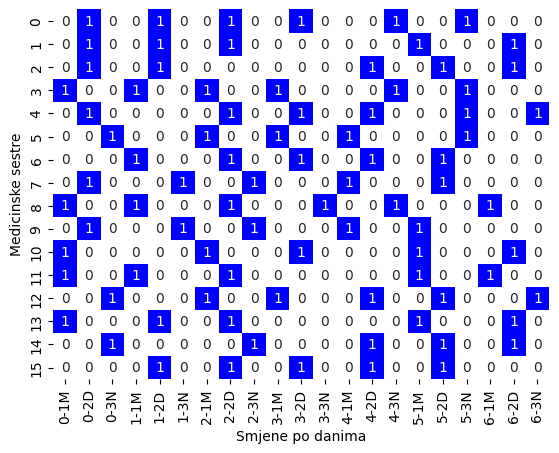

In [15]:
#Scenario 3a - Scenario 2 + sada radi ukupno 16 sestara

from pulp import *
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def NSP_constraints(days, nurses_count, ms,ds,ns,fs, problem, demand, payrates, seniority):
    
    #ogranicenje 1: samo jedna smjena dnevno
    for i in range(days):
        for j in range(nurses_count):
            c = None
            #moze naravno i ms+ds+ns<=1, izdvajamo posebno slobodan dan
            c += ms[i][j] + ds[i][j] + ns[i][j]+fs[i][j]
            problem += c == 1

    #ogranicenje 2: minimalan broj sestra u određenoj smjeni
    for i in range(days):
        morning_shift = None
        day_shift = None
        night_shift = None
        for j in range(nurses_count):
            morning_shift+=2*ms[i][j] if seniority[j]>=7 else ms[i][j]
            day_shift+=2*ds[i][j] if seniority[j]>=7 else ds[i][j]
            night_shift+=2*ns[i][j] if seniority[j]>=7 else ns[i][j]
        
        #uvazena su i gornja ogranicenja   
        problem += morning_shift >= demand[i][0][0]
        problem += morning_shift <= demand[i][0][1]
        problem += day_shift >= demand[i][1][0]
        problem += day_shift <= demand[i][1][1]
        problem += night_shift >= demand[i][2][0]
        problem += night_shift <= demand[i][2][1]

    # ogranicenje 3: u 7 dana minimalno 5 radnih,a maksimalno 6
    for j in range(nurses_count):
        for i in range(0, days-6):
            c = None
            for l in range(7):
                c += ms[i+l][j] + ds[i+l][j]+ns[i+l][j]
            problem += c <= 6
            problem+=c>=5

    # ogranicenje 4: minimalan odmor između dva radna dana iznosi 2 smjene
    for i in range(days-1):
        for j in range(nurses_count):
            c = None
            d= None
            e=None
            c += ns[i][j]+ms[i+1][j]
            d += ns[i][j]+ds[i+1][j]
            e += ds[i][j]+ms[i+1][j]
            problem += c <= 1
            problem += d <= 1
            problem += e <= 1
            
    #ogranicenje 5: nocni rad maksimalno 2 puta sedmicno       
    for j in range(nurses_count):
        for i in range(0, days-6):
            c = None
            for l in range(7):
                c += ns[i+l][j]
            problem += c <= 2
            
def NSP_objective(days, nurses_count, ms,ds,ns,fs, payrates):

    #kriterij - minimizacija novca za plate
    obj = None

    #cijena regularnog rada za sve sestre
    for i in range(days):
        for j in range(nurses_count):
            #nocna 150%, mnozi se sa 8 sati i satnicom
            obj+=(ms[i][j]+ds[i][j]+night_work_coef*ns[i][j])*8*payrates[j]
    
    #cijena prekovremenog rada za sve sestre
    for j in range(nurses_count):
        number_of_shifts=0
        for i in range(days):
            number_of_shifts+=ms[i][j]+ds[i][j]+ns[i][j]
        #0 ili 1
        obj+=(number_of_shifts-5)*8*(overtime_coef-1)*payrates[j]   
        
    return obj

def convert_values_to_int(dict):
    for i in range(len(dict)):
        for j in range(len(dict[0])):
            dict[i][j]=int(dict[i][j].varValue)
            
def convert_dict_of_dicts_to_list_of_lists(dict):
    my_list=[]
    for i in range(len(dict[0])):
        array=[]
        for j in range(len(dict)):
            array.append(int(dict[j][i]))
        my_list.append(array)
    return my_list

#Naredna funkcija je preuzeta sa stack overflowa
#https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png
def save_df_as_image(df, path):
    # Set background to white
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
            [norm( 1.0), "blue"]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    # Make plot
    plot = sns.heatmap(df, annot=True, cmap=cmap, cbar=False)
    fig = plot.get_figure()
    fig.gca().set_xlabel('Smjene po danima')
    fig.gca().set_ylabel('Medicinske sestre')
    fig.savefig(path, bbox_inches="tight")
    
def print_everything(ms,ds,ns,fs, table_name):
    #ms,ds,ns,fs sada imaju vrijednosti 0 ili 1 u sebi
    convert_values_to_int(ms)
    convert_values_to_int(ds)
    convert_values_to_int(ns)
    convert_values_to_int(fs)

    ms=convert_dict_of_dicts_to_list_of_lists(ms)
    ds=convert_dict_of_dicts_to_list_of_lists(ds)
    ns=convert_dict_of_dicts_to_list_of_lists(ns)
    fs=convert_dict_of_dicts_to_list_of_lists(fs)

    schedule=copy.copy(ms)
               
    #od rasporeda za jutro proširi do rasporeda za cijeli dan
    for i in range(len(ms)):
        schedule[i]=ms[i]+ds[i]+ns[i]
        
        
    morning_tuples=[(i,'1M') for i in range(len(ms[0]))]
    day_tuples=[(i,'2D') for i in range(len(ds[0]))]
    night_tuples=[(i,'3N') for i in range(len(ns[0]))]
    #free_tuples=[(i,'F') for i in range(len(fs[0]))]
    cols=pd.MultiIndex.from_tuples(morning_tuples+day_tuples+night_tuples)

    lista=['Nurse '+str(i+1) for i in range(len(ms))]

    df=pd.DataFrame(schedule, columns=cols)
    df=df.sort_index(axis=1, level=0)

    print('Raspored')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df)
        
    save_df_as_image(df, table_name)

    s=df.sum(axis=1)
    s.name='Working days in week'
    df1 = s.to_frame()
    df1=df1.transpose()
    print('Ukupan broj radnih dana u sedmici po sestrama')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df1)

    print()
    s=df.sum(axis=0) 
    s.name='Nurses per shift'
    df2 = s.to_frame()
    df2=df2.transpose()
    print('Ukupan broj medicinskih sestara po smjeni')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df2)
            
#--------------------------------------------------------------------------


#godine iskustva za pojedine sestre
seniority=[7,4,5,1,1,
            2,2,4,9,12,
            5,5,8,4,1, 
            2]

#satnice za pojedice sestre
payrates=[18, 13, 14, 10, 11,
          11, 13, 12, 20, 24,
          15, 16, 19, 17, 12, 
          13]

#minimalan i maksimalan broj medicinskih sestara za određenu smjenu na određeni dan
#dolje navedeni brojevi se odnose na 7 dana, za više dana dodati dodatne liste
demand= [[(6, 9), (8, 13), (4, 8)], [(5, 8), (6, 10), (3, 6)], [(5, 10), (10, 14), (4, 6)],[(4, 7), (6, 9), (2, 5)],
        [(4, 7), (7, 12), (5, 7)], [(6, 9), (7, 10), (5, 7)], [(3, 5), (5, 8), (3, 5)]]
    
days=7
nurses_count=len(payrates)
night_work_coef=1.5
overtime_coef=1.5

#ms,ds,ns,fs skraćeno za morning shift,..., free shift
ms= LpVariable.dicts('Morning', (range(days), range(nurses_count)), 0, 1, 'Binary')
ds = LpVariable.dicts('Day', (range(days), range(nurses_count)), 0, 1, 'Binary')
ns = LpVariable.dicts('Night', (range(days), range(nurses_count)), 0, 1, 'Binary')
fs = LpVariable.dicts('Free', (range(days), range(nurses_count)), 0, 1, 'Binary')

problem = LpProblem('Nurse-scheduling', LpMinimize)   
problem+=NSP_objective(days, nurses_count, ms,ds,ns,fs, payrates)     
NSP_constraints(days, nurses_count, ms,ds,ns,fs, problem, demand, payrates, seniority)


status = problem.solve(pulp.PULP_CBC_CMD(timeLimit=30))
print('Status', LpStatus[status])
print('Vrijednost kriterija: ', value(problem.objective))

if(LpStatus[status]=='Optimal'):
    print_everything(ms,ds,ns,fs, 'table3.png')



Status Optimal
Vrijednost kriterija:  31588.0
Raspored


0        1        2        3        4        5        6      
   1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N
0   0  1  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0
1   1  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  0  0  1  0  0
2   1  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  0  1  0
3   0  0  0  1  0  0  1  0  0  0  0  0  0  1  0  0  0  1  0  0  1
4   0  1  0  0  0  0  0  1  0  0  0  1  0  0  1  0  0  0  0  1  0
5   0  0  1  0  0  0  1  0  0  0  0  1  0  0  0  1  0  0  1  0  0
6   0  0  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  0  0
7   0  1  0  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0  0  0
8   0  0  1  0  0  0  1  0  0  1  0  0  1  0  0  1  0  0  0  0  1
9   0  1  0  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0
10  1  0  0  1  0  0  0  1  0  0  0  0  0  0  0  1  0  0  1  0  0
11  1  0  0  1  0  0  0  1  0  0  0  0  0  1  0  0  1  0  0  0  0
12  0  1  0  0  1  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  0
13  1  0  0  1  0  0  0  1  0  0  1  0  0  0  0  0  1  0  0  0  0
14  0  0  1  0  0  0  0  0  1  0  0  0  0  1  0  0  1  0  0  1  0
15  1  0  0  0  1  0  0  1  0  0  0  0  0  1  0  0  1  0  0  0  0

Ukupan broj radnih dana u sedmici po sestrama


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Working days in week,6,5,5,5,5,5,5,5,6,6,5,5,6,5,5,5



Ukupan broj medicinskih sestara po smjeni


0        1        2        3        4        5        6     \
                 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D 3N 1M 2D   
Nurses per shift  6  5  3  5  4  2  4  8  3  3  4  2  3  6  3  5  6  3  3  4   

                     
                 3N  
Nurses per shift  2

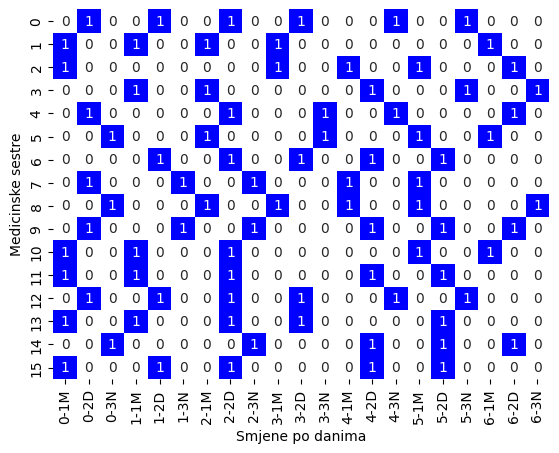

In [16]:
#Scenario 3b - Scenario 3a + jako penaliziran broj overtime dana

from pulp import *
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def NSP_constraints(days, nurses_count, ms,ds,ns,fs, problem, demand, payrates, seniority):
    
    #ogranicenje 1: samo jedna smjena dnevno
    for i in range(days):
        for j in range(nurses_count):
            c = None
            c += ms[i][j] + ds[i][j] + ns[i][j]+fs[i][j]
            problem += c == 1

    #ogranicenje 2: minimalan broj sestra u određenoj smjeni
    for i in range(days):
        morning_shift = None
        day_shift = None
        night_shift = None
        for j in range(nurses_count):
            morning_shift+=2*ms[i][j] if seniority[j]>=7 else ms[i][j]
            day_shift+=2*ds[i][j] if seniority[j]>=7 else ds[i][j]
            night_shift+=2*ns[i][j] if seniority[j]>=7 else ns[i][j]
        
        #uvazena su i gornja ogranicenja   
        problem += morning_shift >= demand[i][0][0]
        problem += morning_shift <= demand[i][0][1]
        problem += day_shift >= demand[i][1][0]
        problem += day_shift <= demand[i][1][1]
        problem += night_shift >= demand[i][2][0]
        problem += night_shift <= demand[i][2][1]

    # ogranicenje 3: u 7 dana minimalno 5 radnih,a maksimalno 6
    for j in range(nurses_count):
        for i in range(0, days-6):
            c = None
            for l in range(7):
                #moze naravno i ms+ds+ns<=1, izdvajamo posebno slobodan dan
                c += ms[i+l][j] + ds[i+l][j]+ns[i+l][j]
            problem += c <= 6
            problem+=c>=5

    # ogranicenje 4: minimalan odmor između dva radna dana iznosi 2 smjene
    for i in range(days-1):
        for j in range(nurses_count):
            c = None
            d= None
            e=None
            c += ns[i][j]+ms[i+1][j]
            d += ns[i][j]+ds[i+1][j]
            e += ds[i][j]+ms[i+1][j]
            problem += c <= 1
            problem += d <= 1
            problem += e <= 1
            
    #ogranicenje 5: nocni rad maksimalno 2 puta sedmicno       
    for j in range(nurses_count):
        for i in range(0, days-6):
            c = None
            for l in range(7):
                c += ns[i+l][j]
            problem += c <= 2
            
def NSP_objective(days, nurses_count, ms,ds,ns,fs, payrates):

    #kriterij - minimizacija novca za plate
    obj = None

    #cijena regularnog rada za sve sestre
    for i in range(days):
        for j in range(nurses_count):
            #nocna 150%, mnozi se sa 8 sati i satnicom
            obj+=(ms[i][j]+ds[i][j]+night_work_coef*ns[i][j])*8*payrates[j]
    
    #cijena prekovremenog rada za sve sestre
    for j in range(nurses_count):
        number_of_shifts=0
        for i in range(days):
            number_of_shifts+=ms[i][j]+ds[i][j]+ns[i][j]
        #0 ili 1
        obj+=(number_of_shifts-5)*8*(overtime_coef-1)*payrates[j]+(number_of_shifts-5)*5000  
        
    return obj

def convert_values_to_int(dict):
    for i in range(len(dict)):
        for j in range(len(dict[0])):
            dict[i][j]=int(dict[i][j].varValue)
            
def convert_dict_of_dicts_to_list_of_lists(dict):
    my_list=[]
    for i in range(len(dict[0])):
        array=[]
        for j in range(len(dict)):
            array.append(int(dict[j][i]))
        my_list.append(array)
    return my_list

#Naredna funkcija je preuzeta sa stack overflowa
#https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png
def save_df_as_image(df, path):
    # Set background to white
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
            [norm( 1.0), "blue"]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    # Make plot
    plot = sns.heatmap(df, annot=True, cmap=cmap, cbar=False)
    fig = plot.get_figure()
    fig.gca().set_xlabel('Smjene po danima')
    fig.gca().set_ylabel('Medicinske sestre')
    fig.savefig(path, bbox_inches="tight")
    
def print_everything(ms,ds,ns,fs, table_name):
    #ms,ds,ns,fs sada imaju vrijednosti 0 ili 1 u sebi
    convert_values_to_int(ms)
    convert_values_to_int(ds)
    convert_values_to_int(ns)
    convert_values_to_int(fs)

    ms=convert_dict_of_dicts_to_list_of_lists(ms)
    ds=convert_dict_of_dicts_to_list_of_lists(ds)
    ns=convert_dict_of_dicts_to_list_of_lists(ns)
    fs=convert_dict_of_dicts_to_list_of_lists(fs)

    schedule=copy.copy(ms)
               
    #od rasporeda za jutro proširi do rasporeda za cijeli dan
    for i in range(len(ms)):
        schedule[i]=ms[i]+ds[i]+ns[i]
        
        
    morning_tuples=[(i,'1M') for i in range(len(ms[0]))]
    day_tuples=[(i,'2D') for i in range(len(ds[0]))]
    night_tuples=[(i,'3N') for i in range(len(ns[0]))]
    #free_tuples=[(i,'F') for i in range(len(fs[0]))]
    cols=pd.MultiIndex.from_tuples(morning_tuples+day_tuples+night_tuples)

    lista=['Nurse '+str(i+1) for i in range(len(ms))]

    df=pd.DataFrame(schedule, columns=cols)
    df=df.sort_index(axis=1, level=0)

    print('Raspored')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df)
        
    save_df_as_image(df, table_name)

    s=df.sum(axis=1)
    s.name='Working days in week'
    df1 = s.to_frame()
    df1=df1.transpose()
    print('Ukupan broj radnih dana u sedmici po sestrama')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df1)

    print()
    s=df.sum(axis=0) 
    s.name='Nurses per shift'
    df2 = s.to_frame()
    df2=df2.transpose()
    print('Ukupan broj medicinskih sestara po smjeni')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
        display(df2)
            
#--------------------------------------------------------------------------


#godine iskustva za pojedine sestre
seniority=[7,4,5,1,1,
            2,2,4,9,12,
            5,5,8,4,1, 
            2]

#satnice za pojedice sestre
payrates=[18, 13, 14, 10, 11,
          11, 13, 12, 20, 24,
          15, 16, 19, 17, 12, 
          13]

#minimalan i maksimalan broj medicinskih sestara za određenu smjenu na određeni dan
#dolje navedeni brojevi se odnose na 7 dana, za više dana dodati dodatne liste
demand= [[(6, 9), (8, 13), (4, 8)], [(5, 8), (6, 10), (3, 6)], [(5, 10), (10, 14), (4, 6)],[(4, 7), (6, 9), (2, 5)],
        [(4, 7), (7, 12), (5, 7)], [(6, 9), (7, 10), (5, 7)], [(3, 5), (5, 8), (3, 5)]]
    
days=7
nurses_count=len(payrates)
night_work_coef=1.5
overtime_coef=1.5

#ms,ds,ns,fs skraćeno za morning shift,..., free shift
ms= LpVariable.dicts('Morning', (range(days), range(nurses_count)), 0, 1, 'Binary')
ds = LpVariable.dicts('Day', (range(days), range(nurses_count)), 0, 1, 'Binary')
ns = LpVariable.dicts('Night', (range(days), range(nurses_count)), 0, 1, 'Binary')
fs = LpVariable.dicts('Free', (range(days), range(nurses_count)), 0, 1, 'Binary')



problem = LpProblem('Nurse-scheduling', LpMinimize)   
problem+=NSP_objective(days, nurses_count, ms,ds,ns,fs, payrates)     
NSP_constraints(days, nurses_count, ms,ds,ns,fs, problem, demand, payrates, seniority)


status = problem.solve(pulp.PULP_CBC_CMD(timeLimit=30))
print('Status', LpStatus[status])
print('Vrijednost kriterija: ', value(problem.objective))

if(LpStatus[status]=='Optimal'):
    print_everything(ms,ds,ns,fs, 'table4.png')


In [12]:
payrates=[18, 13, 14, 10, 11,
          11, 13, 12, 20, 24,
          15, 16, 19, 17, 12, 
          13]

s=pd.Series(payrates)
s.name='Nurse payrate'
df = s.to_frame()
df=df.transpose()
print("Satnice medicinskih sestara")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3): 
    display(df)

Satnice medicinskih sestara


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Nurse payrate,18,13,14,10,11,11,13,12,20,24,15,16,19,17,12,13
